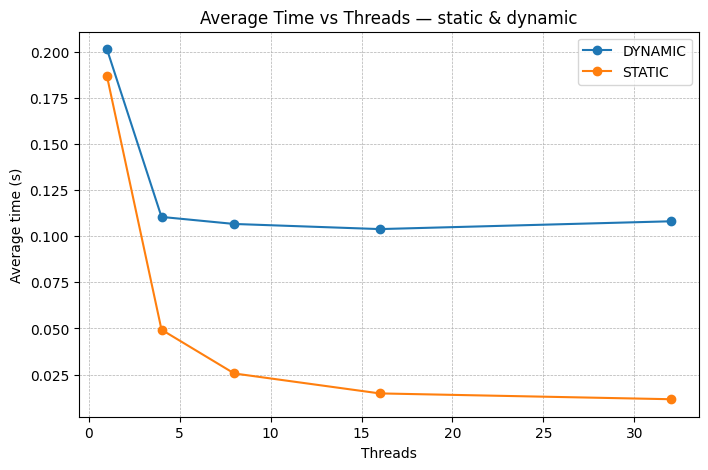

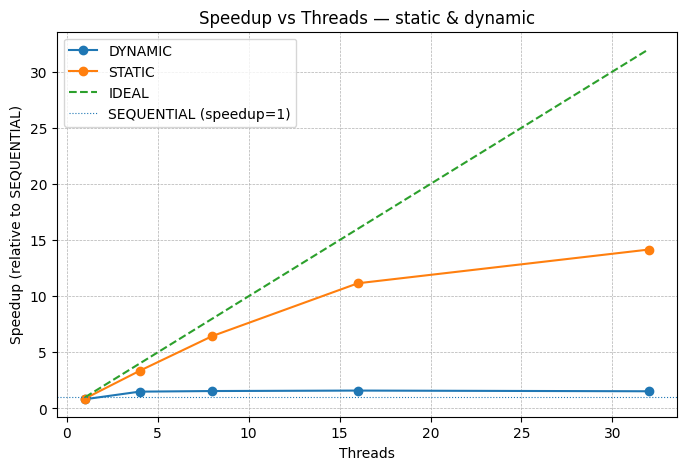

Parsed tidy DataFrame:


,scheduler,threads,avg_time,speedup
0,SEQUENTIAL,1,0.165362,1.000000
1,dynamic,1,0.201292,0.821503
2,dynamic,4,0.110448,1.497189
3,dynamic,8,0.106629,1.550811
4,dynamic,16,0.103852,1.592280
5,dynamic,32,0.108075,1.530066
6,static,1,0.186696,0.885727
7,static,4,0.049340,3.351501
8,static,8,0.025638,6.449982
9,static,16,0.014831,11.149620



Comparison table:


,time_static,time_dynamic,speedup_static,speedup_dynamic,faster_scheduler,time_ratio_dyn_over_stat
threads,,,,,,
1,0.186696,0.201292,0.885727,0.821503,static,1.078179
4,0.049340,0.110448,3.351501,1.497189,static,2.238530
8,0.025638,0.106629,6.449982,1.550811,static,4.159104
16,0.014831,0.103852,11.149620,1.592280,static,7.002299
32,0.011683,0.108075,14.153967,1.530066,static,9.250561


Saved comparison table to: c:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\KmeansOMP\scheduler_compare_table.csv


In [4]:
# ------------------------------
# KMeans: Time & Speedup plots (static vs dynamic)
# Paste into a Jupyter cell. Edit CSV_PATH if needed.
# ------------------------------
CSV_PATH = r"C:\Users\aadii\OneDrive\Desktop\Github\IIScFirstSem\IntrotoScalableSys\Parallel\KmeansOMP\aggr.csv"

import csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------
# Read CSV, discard first column, parse rows with 'average_time_summary'
# ------------------------------
p = Path(CSV_PATH)
if not p.exists():
    raise FileNotFoundError(f"CSV not found at: {CSV_PATH}")

rows = []
with open(p, 'r', encoding='utf-8', errors='replace') as f:
    rdr = csv.reader(f)
    for r in rdr:
        # skip empty lines
        if not r: 
            continue
        # keep only rows that have the marker 'average_time_summary'
        if any('average_time_summary' in (c or '').lower() for c in r):
            # discard first column (id)
            r2 = r[1:]
            rows.append(r2)

if not rows:
    raise ValueError("No rows containing 'average_time_summary' found in CSV.")

# Expecting rows like:
# [mode, scheduler, threads, 'AVG', avg_time, ... , 'average_time_summary']
# We'll parse defensively.
records = []
for r in rows:
    # normalize length
    r = [c.strip() for c in r]
    # mode e.g. SEQUENTIAL or PARALLEL
    mode = r[0] if len(r) > 0 else ''
    # scheduler e.g. seq / static / dynamic
    scheduler = r[1] if len(r) > 1 else ''
    # threads candidate - try index 2
    threads = None
    if len(r) > 2:
        try:
            threads = int(r[2])
        except:
            # fallback: scan for first integer token
            for t in r:
                try:
                    ti = int(t)
                    if ti >= 1:
                        threads = ti
                        break
                except:
                    continue
    if threads is None:
        threads = 1
    # avg_time: look for 'AVG' token and take next token as float; otherwise take first float in row
    avg_time = None
    if 'AVG' in [c.upper() for c in r]:
        try:
            idx = [c.upper() for c in r].index('AVG')
            if idx+1 < len(r):
                avg_time = float(r[idx+1])
        except:
            avg_time = None
    if avg_time is None:
        # find first float-like token
        for tok in r:
            try:
                avg_time = float(tok)
                break
            except:
                continue
    # normalize scheduler label
    sched_label = scheduler.lower()
    if 'seq' in sched_label or 'sequential' in sched_label:
        sched_label = 'SEQUENTIAL'
    elif 'static' in sched_label:
        sched_label = 'static'
    elif 'dynamic' in sched_label:
        sched_label = 'dynamic'
    else:
        sched_label = sched_label or 'unknown'

    if avg_time is None:
        # skip rows without a numeric avg_time
        continue

    records.append({'scheduler': sched_label, 'threads': int(threads), 'avg_time': float(avg_time)})

if not records:
    raise ValueError("No numeric avg_time parsed from selected rows.")

tidy = pd.DataFrame(records)

# ------------------------------
# Baseline: SEQUENTIAL threads==1 -> speedup = 1
# ------------------------------
seq_mask = (tidy['scheduler'] == 'SEQUENTIAL') & (tidy['threads'] == 1)
if tidy[seq_mask].shape[0] > 0:
    baseline_time = float(tidy[seq_mask]['avg_time'].mean())
else:
    # fallback: mean of threads==1 if sequential not exactly labeled
    t1 = tidy[tidy['threads'] == 1]
    baseline_time = float(t1['avg_time'].mean()) if not t1.empty else float(tidy['avg_time'].max())

# compute speedups (explicitly set SEQUENTIAL speedup to 1)
tidy['speedup'] = baseline_time / tidy['avg_time']
tidy.loc[tidy['scheduler'] == 'SEQUENTIAL', 'speedup'] = 1.0

# ------------------------------
# Filter for static and dynamic lines for plotting
# ------------------------------
plot_df = tidy[tidy['scheduler'].isin(['static', 'dynamic'])].copy()
if plot_df.empty:
    raise ValueError("No 'static' or 'dynamic' rows found after parsing. Inspect CSV format.")

# ------------------------------
# Plot: Average Time vs Threads
# ------------------------------
plt.figure(figsize=(8,5))
for name, group in plot_df.groupby('scheduler'):
    g = group.sort_values('threads')
    plt.plot(g['threads'], g['avg_time'], marker='o', label=name.upper())
plt.xlabel('Threads')
plt.ylabel('Average time (s)')
plt.title('Average Time vs Threads — static & dynamic')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# ------------------------------
# Plot: Speedup vs Threads
# ------------------------------
plt.figure(figsize=(8,5))
for name, group in plot_df.groupby('scheduler'):
    g = group.sort_values('threads')
    plt.plot(g['threads'], g['speedup'], marker='o', label=name.upper())
# ideal line
threads_sorted = sorted(plot_df['threads'].unique())
if threads_sorted:
    plt.plot(threads_sorted, threads_sorted, linestyle='--', label='IDEAL')
# mark SEQUENTIAL speedup = 1
plt.axhline(1.0, linestyle=':', linewidth=0.8, label='SEQUENTIAL (speedup=1)')
plt.xlabel('Threads')
plt.ylabel('Speedup (relative to SEQUENTIAL)')
plt.title('Speedup vs Threads — static & dynamic')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# ------------------------------
# Comparison table: exec time ; speedup ; which scheduler is faster
# ------------------------------
pivot_time = tidy.pivot_table(index='threads', columns='scheduler', values='avg_time', aggfunc='mean')
pivot_speed = tidy.pivot_table(index='threads', columns='scheduler', values='speedup', aggfunc='mean')

threads_all = sorted(set(pivot_time.index.tolist()) | set(pivot_speed.index.tolist()))
rows = []
for th in threads_all:
    row = {'threads': th}
    row['time_static'] = pivot_time.at[th, 'static'] if ('static' in pivot_time.columns and th in pivot_time.index) else np.nan
    row['time_dynamic'] = pivot_time.at[th, 'dynamic'] if ('dynamic' in pivot_time.columns and th in pivot_time.index) else np.nan
    row['speedup_static'] = pivot_speed.at[th, 'static'] if ('static' in pivot_speed.columns and th in pivot_speed.index) else np.nan
    row['speedup_dynamic'] = pivot_speed.at[th, 'dynamic'] if ('dynamic' in pivot_speed.columns and th in pivot_speed.index) else np.nan
    # faster scheduler
    if not np.isnan(row['time_static']) and not np.isnan(row['time_dynamic']):
        if row['time_static'] < row['time_dynamic']:
            row['faster_scheduler'] = 'static'
        elif row['time_dynamic'] < row['time_static']:
            row['faster_scheduler'] = 'dynamic'
        else:
            row['faster_scheduler'] = 'tie'
        row['time_ratio_dyn_over_stat'] = row['time_dynamic'] / row['time_static'] if row['time_static'] != 0 else np.nan
    else:
        if not np.isnan(row['time_static']):
            row['faster_scheduler'] = 'static_only'
        elif not np.isnan(row['time_dynamic']):
            row['faster_scheduler'] = 'dynamic_only'
        else:
            row['faster_scheduler'] = 'none'
        row['time_ratio_dyn_over_stat'] = np.nan
    rows.append(row)

compare_df = pd.DataFrame(rows).set_index('threads').sort_index()

# enforce sequential speedup = 1.0 if present
if 'SEQUENTIAL' in tidy['scheduler'].values:
    compare_df['speedup_static'] = compare_df['speedup_static']
    compare_df['speedup_dynamic'] = compare_df['speedup_dynamic']
# (already set in tidy earlier)

# Print & save
print("Parsed tidy DataFrame:")
display(tidy.sort_values(['scheduler','threads']).reset_index(drop=True))

print("\nComparison table:")
display(compare_df)

# save compare table csv (optional)
out = Path.cwd() / "scheduler_compare_table.csv"
compare_df.to_csv(out)
print(f"Saved comparison table to: {out}")

# End
